<a href="https://colab.research.google.com/github/skywalker0803r/deep-learning-ian-goodfellow/blob/master/offline%20DDPG%20general%20form.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam
import pandas as pd
from torch.utils.data import TensorDataset,DataLoader

# config

In [54]:
data_size = 10000 
batch_size = 256 
hidden_size = 128
state_size = 2 # 狀態不可控制 
request_size = 1 # 需求產出
value_size = 1 # 實際產出
action_size = 10  #可控制器數量
time_step = 6 #時間窗格

# data

In [55]:
data = {}
data['state'] = torch.rand(data_size,time_step,state_size)#(B,T,s_dim)
data['request'] = torch.rand(data_size,request_size)#(B,r_dim)
data['action'] = torch.rand(data_size,time_step,action_size)#(B,T,a_dim)
data['value'] = torch.rand(data_size,value_size)#(B,v_dim)
data = TensorDataset(data['state'],data['request'],data['action'],data['value'])
train_iter = DataLoader(data,batch_size,shuffle=False)

# R2D2 MODEL

In [56]:
class R2D2(nn.Module):
  def __init__(self,obs_size,n_actions,hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.l1 = nn.Linear(obs_size,self.hidden_size)
    self.l2 = nn.LSTMCell(self.hidden_size,self.hidden_size)
    self.l3 = nn.Linear(self.hidden_size,n_actions)
  
  def forward(self,x,hx,cx):
    x = torch.tanh(self.l1(x))
    hx,cx = self.l2(x,(hx,cx))
    x = torch.tanh(hx)
    x = torch.sigmoid(self.l3(x)) # to range[0,1]
    return x,hx,cx

# ActorCritic Model

In [57]:
class ActorCritic(nn.Module):
  def __init__(self,actor,critic,time_step):
    super().__init__()
    self.time_step = time_step
    
    self.actor = actor
    self.actor_optimizer = Adam(actor.parameters())
    
    self.critic = critic
    self.critic_optimizer = Adam(critic.parameters())
  
  def forward(self):
    raise NotImplementedError

  def actor_forward(self,state,request,eval=False):
    '''
    # 給定狀態(不可控)和需求 輸出一系列動作
    '''
    # train or eval model
    if eval == True:
      self.actor.eval()
    else:
      self.actor.train()
    
    # initialize hx,cx
    hx = torch.zeros((state.size()[0],actor.hidden_size))
    cx = torch.zeros((state.size()[0],actor.hidden_size))
    
    # get actions shape(batch_size,time_step,action_size)
    actions = torch.FloatTensor()
    
    # 對一定時間長度進行遍歷
    for t in range(self.time_step):
      # 在t時刻 根據t時刻的狀態,需求以及短期記憶hx,長期記憶cx當作輸入,得到輸出a(動作),更新後的短期記憶hx,更新後的長期記憶cx
      a,hx,cx = self.actor(torch.cat((state[:,t,:],request),dim=1),hx,cx)
      actions = torch.cat((actions,a),dim=1)
    # 一系列動作 (Batch,Time,Features)
    actions = actions.reshape(state.size()[0],self.time_step,-1)
    
    return actions
  
  def critic_forward(self,state,action,eval=False):
    '''
    # 輸入狀態(不可控)和一系列動作(可控),預測產出
    '''

    # train or eval model
    if eval == True:
      self.critic.eval()
    else:
      self.critic.train()
    
    # initialize hx,cx
    hx = torch.zeros((state.size()[0],critic.hidden_size))
    cx = torch.zeros((state.size()[0],critic.hidden_size))

    # get values shape(batch_size,time_step,value_size)
    values = torch.FloatTensor()
    
    # 對時間點遍歷
    for t in range(self.time_step):
      # 根據當前t時刻狀態,動作,hx,cx當輸入得到,v(產出),更新hx,cx
      v,hx,cx = self.critic(torch.cat((state[:,t,:],action[:,t,:]),dim=1),hx,cx)
      values = torch.cat((values,v),dim=1)
    
    # 一系列產出(Batch,Time,Features)
    values = values.reshape(state.size()[0],self.time_step,-1)
    
    # 只取最後一個時間點
    return values[:,-1,:] # return last time_step

  def train_critic(self,state,action,value):
    '''
    x: [state,action]
    y: [value]
    '監督式學習'
    '''
    self.critic.train()
    self.actor.eval()
    value_hat = self.critic_forward(state,action)
    
    # 預測值跟label的平方差愈小愈好
    loss = ((value_hat-value)**2).mean()
    loss.backward()
    self.critic_optimizer.step()
    self.critic_optimizer.zero_grad()
    return loss.item()
  
  def train_actor(self,state,request):
    '''
    x: [state,request]
    y: maximum critic value
    '最小化產出跟request的差異'
    '''
    self.actor.train()
    self.critic.eval()
    actions = self.actor_forward(state,request)
    value_hat = self.critic_forward(state,actions)

    # 首先預測值跟需求的平方差愈小愈好
    loss1 = ((request-value_hat)**2).mean()

    # 再來避免"變異數太大(時間維度上)" 因為盤控人員不可能突然調太多
    loss2 = actions.reshape(-1,time_step,action_size).std(axis=1)
    loss2 = loss2.sum(axis=-1).mean(axis=0)

    loss = loss1 + loss2
    loss.backward()
    
    self.actor_optimizer.step()
    self.actor.zero_grad()

    return loss.item()

In [58]:
actor = R2D2(state_size+request_size,action_size,hidden_size)
critic = R2D2(state_size+action_size,value_size,hidden_size)
model = ActorCritic(actor,critic,time_step)

# train loop

In [59]:
def train_critic():
  loss = 0
  for i,(bs,br,ba,bv) in enumerate(train_iter):
    loss += model.train_critic(bs,ba,bv)
  return loss

def train_actor():
  loss = 0
  for i,(bs,br,ba,bv) in enumerate(train_iter):
    loss += model.train_actor(bs,br)
  return loss

def train(model,train_iter,epochs=100):
  train_history = {}
  train_history['actor'] = []
  train_history['critic'] = []
  
  for epoch in range(epochs):
    loss = train_critic()
    train_history['critic'].append(loss)
    print('epoch:{} critic_loss:{}'.format(epoch,loss))
    
  for epoch in range(epochs):
    loss = train_actor()
    train_history['actor'].append(loss)
    print('epoch:{} actor_loss:{}'.format(epoch,loss))
    
  return model,train_history

In [60]:
s,r,a,v = next(iter(train_iter))
actions = model.actor_forward(s,r,eval=True)
pd.DataFrame(actions[0].detach().numpy()).style.background_gradient()

,0,1,2,3,4,5,6,7,8,9
0,0.509056,0.500725,0.508568,0.498531,0.512410,0.511736,0.475408,0.482039,0.506948,0.507911
1,0.511012,0.498590,0.507065,0.496293,0.509685,0.506948,0.474098,0.482794,0.510546,0.509424
2,0.507845,0.496618,0.502533,0.492375,0.509037,0.504509,0.470390,0.484843,0.513824,0.511038
3,0.508113,0.493686,0.504857,0.489806,0.506378,0.503838,0.470533,0.483082,0.512154,0.511205
4,0.505982,0.489807,0.503253,0.487062,0.506110,0.504830,0.468101,0.483232,0.510777,0.511827
5,0.509713,0.491925,0.504617,0.488609,0.506132,0.502472,0.470689,0.483797,0.512068,0.511500


In [61]:
model,train_history = train(model,train_iter,epochs=100)

epoch:0 critic_loss:3.3334175795316696
epoch:1 critic_loss:3.3169832974672318
epoch:2 critic_loss:3.3151112496852875
epoch:3 critic_loss:3.312825493514538
epoch:4 critic_loss:3.308452360332012
epoch:5 critic_loss:3.3036566227674484
epoch:6 critic_loss:3.296585015952587
epoch:7 critic_loss:3.288231700658798
epoch:8 critic_loss:3.278705209493637
epoch:9 critic_loss:3.2652004063129425
epoch:10 critic_loss:3.247616373002529
epoch:11 critic_loss:3.226266473531723
epoch:12 critic_loss:3.1987193934619427
epoch:13 critic_loss:3.1629710495471954
epoch:14 critic_loss:3.11841207370162
epoch:15 critic_loss:3.0643444508314133
epoch:16 critic_loss:3.0012056194245815
epoch:17 critic_loss:2.926929065026343
epoch:18 critic_loss:2.851033399812877
epoch:19 critic_loss:2.7898307046853006
epoch:20 critic_loss:2.7107542771846056
epoch:21 critic_loss:2.6010511238127947
epoch:22 critic_loss:2.471614940557629
epoch:23 critic_loss:2.3337127476697788
epoch:24 critic_loss:2.1601085196016356
epoch:25 critic_loss:1

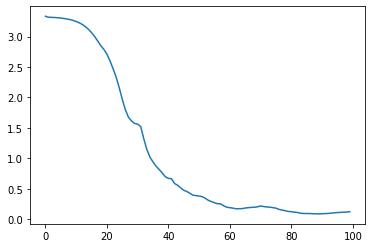

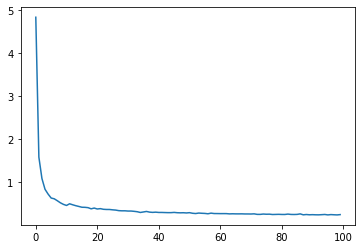

In [62]:
import matplotlib.pyplot as plt

plt.plot(train_history['critic'])
plt.show()
plt.plot(train_history['actor'])

In [63]:
s,r,a,v = next(iter(train_iter))
actions = model.actor_forward(s,r,eval=True)

In [64]:
pd.DataFrame(actions[0].detach().numpy()).style.background_gradient()

,0,1,2,3,4,5,6,7,8,9
0,0.512288,0.596267,0.047022,0.545088,0.155675,0.480824,0.738578,0.687687,0.745513,0.386887
1,0.511819,0.596289,0.047092,0.545251,0.155824,0.480977,0.737868,0.688360,0.745671,0.386973
2,0.511943,0.596249,0.047034,0.545208,0.155775,0.480930,0.738519,0.687655,0.745535,0.386982
3,0.512027,0.596244,0.047059,0.545277,0.155742,0.480956,0.738096,0.688287,0.745692,0.386996
4,0.512265,0.596156,0.047043,0.545226,0.155682,0.480933,0.738491,0.687840,0.745626,0.387027
5,0.511809,0.596301,0.047095,0.545279,0.155782,0.480986,0.737817,0.688432,0.745739,0.386961


In [65]:
values = model.critic_forward(s[[0]],actions[[0]],eval=True)
values

tensor([[0.2632]], grad_fn=<SliceBackward>)

# 令廠商想要控制某種產出率為0.9,其中state(s)不可控,則用法為

In [89]:
wanna_ouput = 0.9
state_setting = 0.5
s = torch.full((1,time_step,state_size),state_setting)
r = torch.full((1,request_size),wanna_ouput)
a = model.actor_forward(s,r,eval=True)
v = model.critic_forward(s,a,eval=True)
print(f'state{s.numpy()}\n')
print(f'request{r.numpy()}\n')

state[[[0.5 0.5]
  [0.5 0.5]
  [0.5 0.5]
  [0.5 0.5]
  [0.5 0.5]
  [0.5 0.5]]]

request[[0.9]]



In [90]:
# 模型建議操作
pd.DataFrame(a[0].detach().numpy()).style.background_gradient()

,0,1,2,3,4,5,6,7,8,9
0,0.107064,0.901936,0.823701,0.615867,0.565087,0.564223,0.006132,0.989680,0.808055,0.332253
1,0.107335,0.901594,0.822804,0.616060,0.564105,0.564091,0.006155,0.989698,0.808479,0.332540
2,0.107429,0.901496,0.822613,0.616059,0.563945,0.564066,0.006161,0.989694,0.808507,0.332580
3,0.107447,0.901484,0.822587,0.616061,0.563920,0.564065,0.006164,0.989691,0.808518,0.332590
4,0.107458,0.901478,0.822574,0.616061,0.563896,0.564067,0.006166,0.989690,0.808518,0.332593
5,0.107458,0.901478,0.822573,0.616060,0.563885,0.564069,0.006166,0.989690,0.808517,0.332593


In [91]:
# 模型預測根據上述操作應當的產出
print(f'value:{v.detach().numpy()[0][0]}\n') 

value:0.9009560346603394

